In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import emcee
import corner
from astropy.modeling import models
import astropy.units as u
from astropy.io import fits
from scipy.stats import norm, uniform
from IPython.display import display, Math
from chainconsumer import ChainConsumer
import pickle as pk
from pixell import enmap,utils, reproject, enplot


%matplotlib inline

In [3]:
def tileFinder(ra, dec, data):
    #Given an RA and Dec in deg, find the S18d tile containing that RA and Dec
    for i, tile in enumerate(data):
        box = tile['RADecSection']
        if box[0] >= box[1]:
            if (360 >= ra >= box[0] or 0 <= ra <box[1]) and box[2]<=dec<= box[3]:
                return tile['tileName']
        if box[0]<=ra<=box[1] and box[2]<=dec<= box[3]:
            return tile['tileName']
    return None

In [4]:
def central_emission(hmap, max_sep):
    #Returns the average surface brightness in Jy/pixel of pixels within max_sep of the center of hmap (assuming hmap has units MJy/pixel)
    #CODE ONLY WORKS WITH ACT220 DUE TO HARD CODED PIXEL_SIZE
    center = hmap.shape[0]/2 - 0.5
    
    pixel_size = 0.0083333333*60

    emission = 0
    div = 0
    
    data = hmap[0]
    
    for i in range(data.shape[0]):
        for j in range(data.shape[0]):
            if pixel_size*np.sqrt((center-i)**2+(center-j)**2) <= max_sep:

                emission += data[i,j]
                div +=1
    return emission, div

In [5]:
def s18dStamp(ra, dec, data, name, width = 0.5, write = True):
    #Find tile corresponding to RA, Dec

    path = '/project/r/rbond/jorlo/S18d_202006/filteredMaps/'
    tileName = tileFinder(ra, dec, data)
    if tileName == None: return None
    tile = enmap.read_map(path+tileName+'/Arnaud_M2e14_z0p4#'+tileName+'_filteredMap.fits')
    
    
    stamp = reproject.postage_stamp(tile, ra, dec, width*60, 0.5)
    
    if write:
        stamp.wcs.wcs.crval = [ra,dec]
        enmap.write_map('./for_tony/{}.fits'.format(name), stamp)
    return stamp

In [6]:
def log_likelihood(theta, x, y, yerr):
    T_guess, a_guess, v_0_guess, beta_guess, log_f = theta
    #T_guess, a_guess, log_f = theta
    y, yerr =  y.value, yerr.value
    model = lambda v: a_guess*(1-np.exp(-(v.value/(v_0_guess))**beta_guess))*models.BlackBody(temperature = T_guess*u.K, scale = 1*u.MJy/u.sr)(v).value
    
    #model = lambda v: a_guess*(1-np.exp(-(v.value/3000)**1.95))*models.BlackBody(temperature = T_guess*u.K, scale = 1*u.MJy/u.sr)(v).value
    
    sigma2 = yerr ** 2 + model(x) ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model(x)) ** 2 / sigma2 + np.log(sigma2))

In [7]:
def v0_fixed_log_likelihood(theta, x, y, yerr):
    T_guess, a_guess, beta_guess, log_f = theta
    #T_guess, a_guess, log_f = theta
    y, yerr =  y.value, yerr.value
    model = lambda v: a_guess*(1-np.exp(-(v.value/(3000))**beta_guess))*models.BlackBody(temperature = T_guess*u.K, scale = 1*u.MJy/u.sr)(v).value
    
    #model = lambda v: a_guess*(1-np.exp(-(v.value/3000)**1.95))*models.BlackBody(temperature = T_guess*u.K, scale = 1*u.MJy/u.sr)(v).value
    
    sigma2 = yerr ** 2# + model(x) ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model(x)) ** 2 / sigma2)# + np.log(sigma2))

In [8]:
def t_only_log_likelihood(theta, x, y, yerr):
    T_guess, a_guess, log_f = theta
    y, yerr =  y.value, yerr.value
    model = lambda v: a_guess*(1-np.exp(-(v.value/3000)**1.95))*models.BlackBody(temperature = T_guess*u.K, scale = 1*u.MJy/u.sr)(v).value
        
    sigma2 = yerr ** 2 + model(x) ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model(x)) ** 2 / sigma2 + np.log(sigma2))

In [9]:
def spectral_log_likelihood(theta, x, y, yerr):
    a_guess, x_0_guess, alpha_guess, log_f = theta
    y, yerr =  y.value, yerr.value
    model = models.PowerLaw1D(amplitude = a_guess*u.MJy/u.sr, x_0 = x_0_guess*u.GHz, alpha = alpha_guess)

    sigma2 = yerr ** 2 + model(x).value ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model(x).value) ** 2 / sigma2 + np.log(sigma2))

In [10]:
def log_prior(theta):
    T_guess, a_guess, v_0_guess, beta_guess, log_f = theta
    """
    if T_guess > 0.1:
        T_prior = norm(loc = 30, scale = 20).pdf(T_guess)
    else:
        T_prior = -np.inf
    a_prior = uniform().pdf(a_guess)
    log_f_prior = uniform(loc = -10, scale = 20).pdf(log_f)

    if np.isnan(T_prior*a_prior*log_f_prior):
        print(T_prior, a_prior, log_f_prior)
    return T_prior*a_prior*log_f_prior
    """
    if 0 < T_guess < 200 and 0 < a_guess < 1 and 0 < v_0_guess < 10000 and -5< beta_guess< 10 and -10.0 < log_f < 1.0:
    #if 0 < T_guess < 200 and 0<a_guess<1 and 0<v_0_guess< 100 and -5< beta_guess< 10 -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [11]:
def v0_fixed_log_prior(theta):
    T_guess, a_guess, beta_guess, log_f = theta
    if 0 < T_guess < 200 and 0<a_guess<1 and -5< beta_guess< 10 and -50.0 < log_f < 10.0:
    #if 0 < T_guess < 200 and 0<a_guess<1 and 0<v_0_guess< 100 and -5< beta_guess< 10 -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [12]:
def t_only_log_prior(theta):
    T_guess, a_guess, log_f = theta
    if 0 < T_guess < 200 and 0 < a_guess < 1  and -20.0 < log_f < 10.0:
        return 0.0
    return -np.inf
    

In [13]:
def spectral_log_prior(theta):
    a_guess, x_0_guess, alpha_guess, log_f = theta
    """
    if T_guess > 0.1:
        T_prior = norm(loc = 30, scale = 20).pdf(T_guess)
    else:
        T_prior = -np.inf
    a_prior = uniform().pdf(a_guess)
    log_f_prior = uniform(loc = -10, scale = 20).pdf(log_f)

    if np.isnan(T_prior*a_prior*log_f_prior):
        print(T_prior, a_prior, log_f_prior)
    return T_prior*a_prior*log_f_prior
    """
    if 0 < a_guess < 10 and 0.0 < x_0_guess < 10000 and -5 < alpha_guess < 10 and -50.0 < log_f < 1.0:
        
        return 0.0
    return -np.inf

In [14]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    if np.isnan(lp + log_likelihood(theta, x, y, yerr)):
        print(theta,log_likelihood(theta, x, y, yerr))
    return lp + log_likelihood(theta, x, y, yerr)

In [15]:
def v0_fixed_log_probability(theta, x, y, yerr):
    lp = v0_fixed_log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    if np.isnan(lp + v0_fixed_log_likelihood(theta, x, y, yerr)):
        print(theta,v0_fixed_log_likelihood(theta, x, y, yerr))
    return lp + v0_fixed_log_likelihood(theta, x, y, yerr)

In [16]:
def t_only_log_probability(theta, x, y, yerr):
    lp = t_only_log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    if np.isnan(lp + t_only_log_likelihood(theta, x, y, yerr)):
        print(theta,t_only_log_likelihood(theta, x, y, yerr))
    return lp + t_only_log_likelihood(theta, x, y, yerr)

In [17]:
def spectral_log_probability(theta, x, y, yerr):
    lp = spectral_log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    if np.isnan(lp + spectral_log_likelihood(theta, x, y, yerr)):
        print(theta,spectral_log_likelihood(theta, x, y, yerr))
    return lp + spectral_log_likelihood(theta, x, y, yerr)

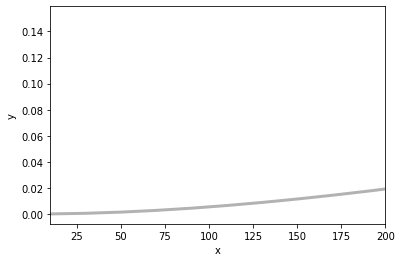

In [17]:
np.random.seed(123)

# Choose the "true" parameters.
#alpha_true = 1
#amp_true = 2
#x_0_true = 50

T_true = 20
a_true = 1e-6

f_true = 0.1

#power_law = models.PowerLaw1D(amplitude = amp_true, x_0 = x_0_true, alpha = alpha_true)

bb = models.BlackBody(temperature = T_true*u.K, scale = a_true * u.MJy/u.sr)
"""
# Generate some synthetic data from the model.
N = 50
#x = np.linspace(10,100, N)
x = np.linspace(10, 1000, N) * u.GHz
yerr = (0.01 + 0.05 * np.random.rand(N))*u.MJy/u.sr
#y = power_law(x)
y = bb(x)
y += np.abs(f_true * y) * 0.1*np.random.randn(N)
y += yerr * np.random.randn(N)
"""


#plt.errorbar(x.value, y.value, yerr=yerr.value, fmt=".k", capsize=0)
x0 = np.linspace(10, 2000, 100)*u.GHz
plt.plot(x0, bb(x0), "k", alpha=0.3, lw=3)
plt.xlim(10, 200)
plt.xlabel("x")
plt.ylabel("y");


In [18]:
x = np.array([1362.69, 250, 350, 500])*u.um
x = x.to(u.GHz, equivalencies=u.spectral())
print(x)
#y_18 = [4*0.00701, 0.231989, 0.1782091, 0.09595372]*u.MJy/u.sr
y_24 = [0.0044044, 0.21843581, 0.16337599, 0.08575974]*u.MJy/u.sr

y = y_24
yerr = np.array([0.0006369, 0.01451, 0.011704, 0.0075511])*u.MJy/u.sr

f_true = 0.1

i = 0
x, y, yerr = x[i:], y[i:], yerr[i:]


[ 220.00048287 1199.169832    856.54988     599.584916  ] GHz


Maximum likelihood estimates:
T = 61.259
amp = 1.167e-07
v_0 = 2.000
beta = 1.950
f = 3.856e-01


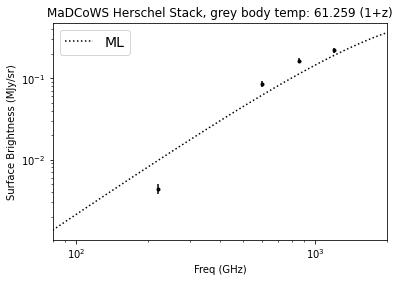

In [19]:
nll = lambda *args: -log_likelihood(*args)
initial = np.array([20, 1e-5, 2, 1.95, np.log(f_true)])

soln = minimize(nll, initial, args=(x, y, yerr))
T_ml, a_ml, v_0_ml, beta_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("T = {0:.3f}".format(T_ml))
print("amp = {0:.3e}".format(a_ml))
print("v_0 = {0:.3f}".format(v_0_ml))
print("beta = {0:.3f}".format(beta_ml))

print("f = {0:.3e}".format(np.exp(log_f_ml)))

model_ml = lambda v: a_ml*(1.-np.exp(-(v.value/(v_0_ml))**beta_ml))*models.BlackBody(temperature = T_ml*u.K, scale = 1*u.MJy/u.sr)(v).value

x0 = np.linspace(80, 2000, 100)*u.GHz

plt.errorbar(x.value, y.value, yerr=yerr.value, fmt=".k", capsize=0)
#plt.plot(x0, bb(x0), "k", alpha=0.3, lw=3, label = 'Truth')
plt.plot(x0, model_ml(x0), ":k", label="ML")
plt.title('MaDCoWS Herschel Stack, grey body temp: {0:.3f} (1+z)'.format(T_ml) )
plt.legend(fontsize=14)
plt.xlim(80, 2000)
plt.xscale('log')
plt.yscale('log')


plt.xlabel("Freq (GHz)")
plt.ylabel("Surface Brightness (MJy/sr)");

In [22]:
print(soln.x)

[ 6.12592952e+01  1.16747192e-07  2.00000000e+00  1.95000000e+00
 -9.53031141e-01]


In [23]:
pos = soln.x + 1e-4 * np.random.randn(32, 5)
nwalkers, ndim = pos.shape
print(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 1/5000 [00:00<22:05,  3.77it/s]

32 5


  0%|          | 13/5000 [00:03<22:48,  3.64it/s]Traceback (most recent call last):
  File "/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-13-6da6138bd18e>", line 7, in log_probability
    return lp + log_likelihood(theta, x, y, yerr)
  File "<ipython-input-5-2efcf7fa46e8>", line 9, in log_likelihood
    sigma2 = yerr ** 2 + model(x) ** 2 * np.exp(2 * log_f)
  File "<ipython-input-5-2efcf7fa46e8>", line 5, in <lambda>
    model = lambda v: a_guess*(1-np.exp(-(v.value/(v_0_guess))**beta_guess))*models.BlackBody(temperature = T_guess*u.K, scale = 1*u.MJy/u.sr)(v).value
  File "/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/modeling/core.py", line 402, in __call__
    __call__, args, kwargs, varargs='inputs', varkwargs='new_inputs')
  File "/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/modeling/core.py", line 380, in __call__

emcee: Exception while calling your likelihood function:
  params: [ 6.12590379e+01  5.28800631e-06  2.00054244e+00  1.95096669e+00
 -9.52641929e-01]
  args: (<Quantity [ 220.00048287, 1199.169832  ,  856.54988   ,  599.584916  ] GHz>, <Quantity [0.0044044 , 0.21843581, 0.16337599, 0.08575974] MJy / sr>, <Quantity [0.0006369, 0.01451  , 0.011704 , 0.0075511] MJy / sr>)
  kwargs: {}
  exception:


KeyboardInterrupt: 

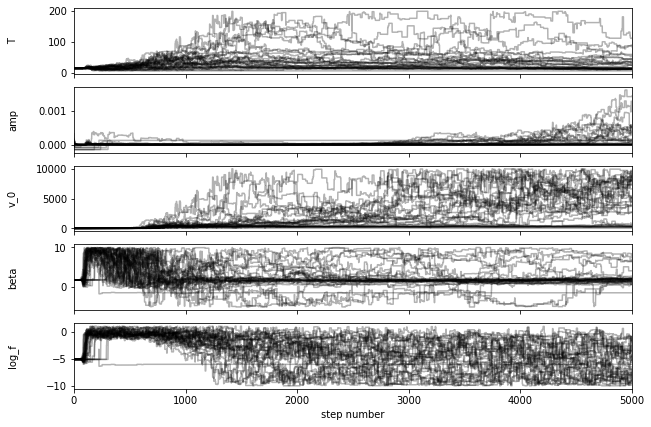

In [57]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['T', 'amp', 'v_0', 'beta', 'log_f']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [191]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [518.35856034 527.1039673  569.85112561 510.83831005 257.5743194 ]

In [192]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)

(8512, 5)


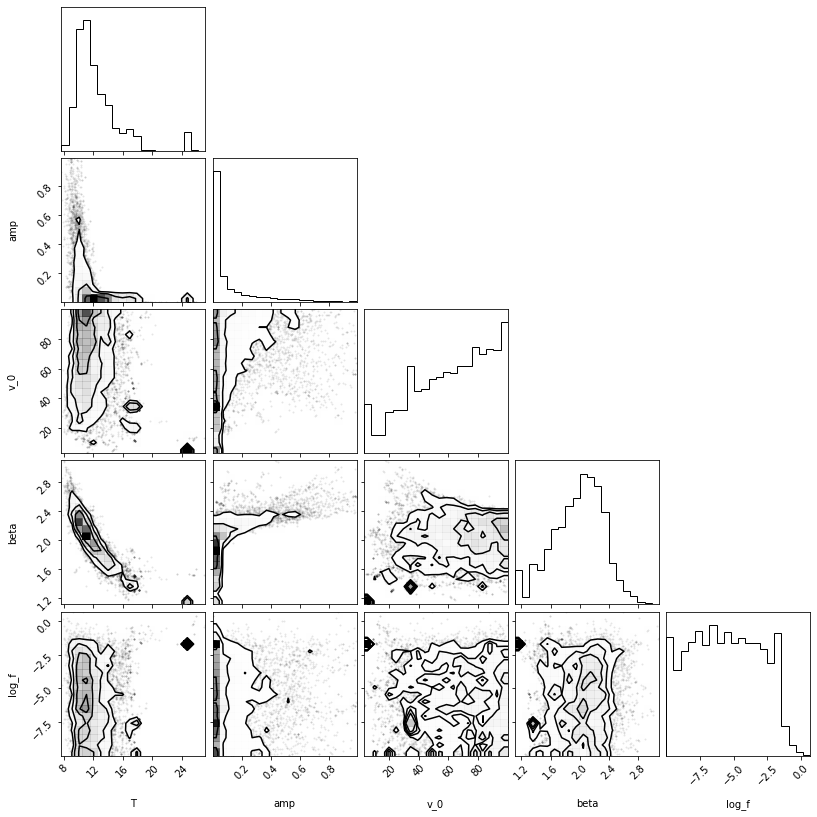

In [193]:
fig = corner.corner(
    flat_samples, labels=labels
);

In [195]:
labels = ['T', 'amp', 'v_0', 'beta', 'log_f']
for i in range(5):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = r"$\mathrm{{{3}}}/(1+z)= {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    
    if labels[i] == 'T':
        title = txt
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

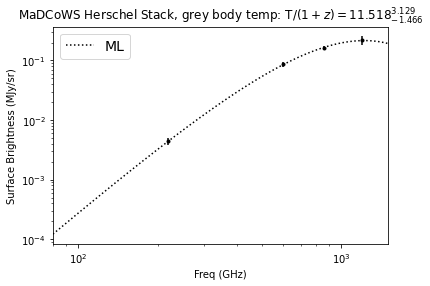

In [200]:
plt.errorbar(x.value, y.value, yerr=yerr.value, fmt=".k", capsize=0)
#plt.plot(x0, bb(x0), "k", alpha=0.3, lw=3, label = 'Truth')

model_ml = lambda v: a_ml*(1-np.exp(-(v.value/(v_0_ml*1000))**beta_ml))*models.BlackBody(temperature = T_ml*u.K, scale = 1*u.MJy/u.sr)(v).value

plt.plot(x0, model_ml(x0), ":k", label="ML")
plt.title('MaDCoWS Herschel Stack, grey body temp: '+ title )
plt.legend(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlim(80, 1500)

plt.savefig('./plots/herschel/greybody_mdcw_mcmc.pdf')
plt.savefig('./plots/herschel/greybody_mdcw_mcmc.png', dpi = 300)

plt.xlabel("Freq (GHz)")
plt.ylabel("Surface Brightness (MJy/sr)");

# Spectral Index Fitting

Maximum likelihood estimates:
alpha = -1.455
amp = 1.103e+00
x_0 = 3382.538
f = 1.465e-04


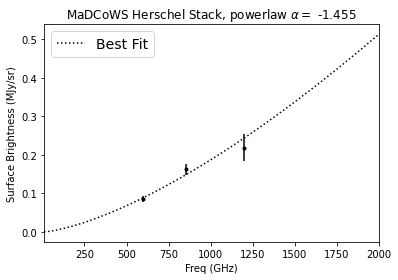

In [80]:
nll = lambda *args: -spectral_log_likelihood(*args)
initial = np.array([1.6974878505056523, 3382.53674018168, -1.7246324134177595, np.log(f_true)])

soln = minimize(nll, initial, args=(x, y, yerr))
amp_ml, x_0_ml, alpha_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("alpha = {0:.3f}".format(alpha_ml))
print("amp = {0:.3e}".format(amp_ml))
print("x_0 = {0:.3f}".format(x_0_ml))
print("f = {0:.3e}".format(np.exp(log_f_ml)))

plt.errorbar(x.value, y.value, yerr=yerr.value, fmt=".k", capsize=0)
#plt.plot(x0, bb(x0), "k", alpha=0.3, lw=3, label = 'Truth')
plt.plot(x0, models.PowerLaw1D(amplitude = amp_ml*u.MJy/u.sr, x_0 = x_0_ml*u.GHz, alpha = alpha_ml)(x0), ":k", label="Best Fit")
plt.title(r'MaDCoWS Herschel Stack, powerlaw $\alpha = $ {0:.3f}'.format(alpha_ml) )
plt.legend(fontsize=14)
plt.xlim(10, 2000)

#plt.savefig('./plots/herschel/blackbody_mdcw.pdf')
#plt.savefig('./plots/herschel/blackbody_mdcw.png', dpi = 300)

plt.xlabel("Freq (GHz)")
plt.ylabel("Surface Brightness (MJy/sr)");

In [81]:
pos = soln.x + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, spectral_log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [04:31<00:00, 18.44it/s]


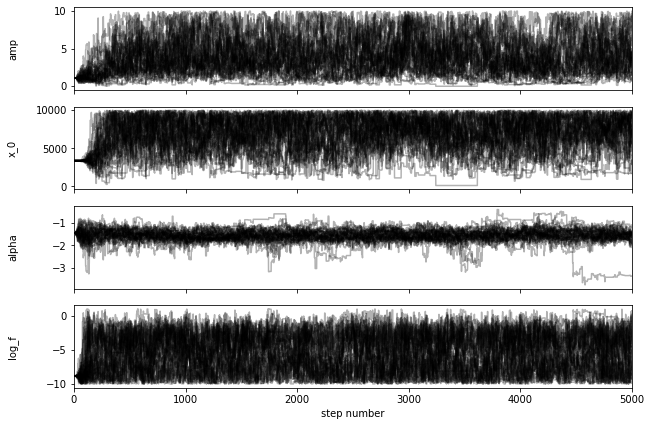

In [83]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['amp', 'x_0', 'alpha', 'log_f']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [84]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [182.18264394 180.41597775 154.96957133 128.12331266]

In [88]:
flat_samples = sampler.get_chain(discard=300, thin=15, flat=True)
print(flat_samples.shape)

(10016, 4)


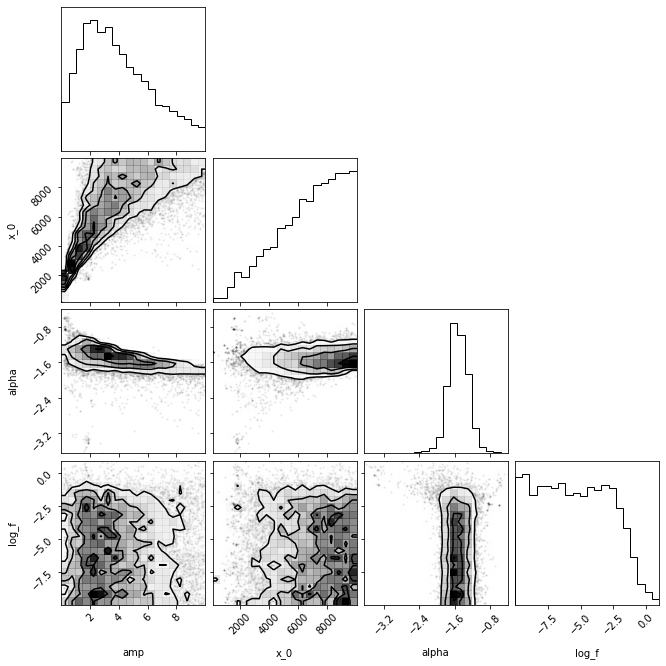

In [89]:
fig = corner.corner(
    flat_samples, labels=labels
);

In [94]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = r"$\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    
    if labels[i] == 'alpha':
        title = txt
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

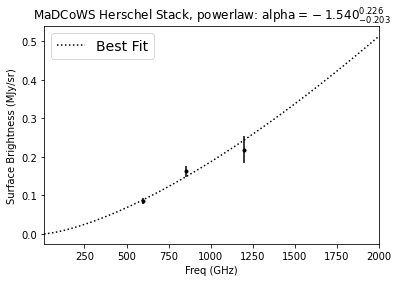

In [95]:

plt.title(r'MaDCoWS Herschel Stack, powerlaw: '+ title )
plt.errorbar(x.value, y.value, yerr=yerr.value, fmt=".k", capsize=0)
#plt.plot(x0, bb(x0), "k", alpha=0.3, lw=3, label = 'Truth')
plt.plot(x0, models.PowerLaw1D(amplitude = amp_ml*u.MJy/u.sr, x_0 = x_0_ml*u.GHz, alpha = alpha_ml)(x0), ":k", label="Best Fit")
plt.legend(fontsize=14)
plt.xlim(10, 2000)

plt.savefig('./plots/herschel/spectral_mdcw_mcmc.pdf')
plt.savefig('./plots/herschel/spectral_mdcw_mcmc.png', dpi = 300)

plt.xlabel("Freq (GHz)")
plt.ylabel("Surface Brightness (MJy/sr)");

# Fixed v_0, beta fit

Maximum likelihood estimates:
T = 12.067
amp = 6.285e-05
f = 1.576e-05


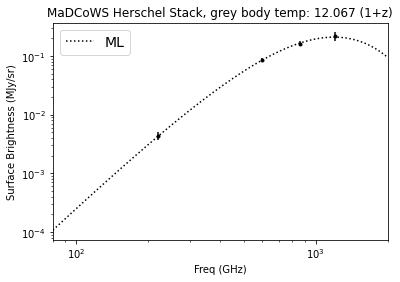

In [15]:
nll = lambda *args: -t_only_log_likelihood(*args)
initial = np.array([20, 1e-5, np.log(f_true)])

soln = minimize(nll, initial, args=(x, y, yerr))
T_ml, a_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("T = {0:.3f}".format(T_ml))
print("amp = {0:.3e}".format(a_ml))


print("f = {0:.3e}".format(np.exp(log_f_ml)))

model_ml = lambda v: a_ml*(1-np.exp(-(v.value/3000)**1.95))*models.BlackBody(temperature = T_ml*u.K, scale = 1*u.MJy/u.sr)(v).value

x0 = np.linspace(80, 2000, 100)*u.GHz

plt.errorbar(x.value, y.value, yerr=yerr.value, fmt=".k", capsize=0)
#plt.plot(x0, bb(x0), "k", alpha=0.3, lw=3, label = 'Truth')
plt.plot(x0, model_ml(x0), ":k", label="ML")
plt.title('MaDCoWS Herschel Stack, grey body temp: {0:.3f} (1+z)'.format(T_ml) )
plt.legend(fontsize=14)
plt.xlim(80, 2000)
plt.xscale('log')
plt.yscale('log')


plt.xlabel("Freq (GHz)")
plt.ylabel("Surface Brightness (MJy/sr)");

In [16]:
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, t_only_log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 4/5000 [00:01<34:41,  2.40it/s]Traceback (most recent call last):
  File "/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-12-67261b510a50>", line 5, in t_only_log_probability
    if np.isnan(lp + t_only_log_likelihood(theta, x, y, yerr)):
  File "<ipython-input-4-1d3a59a37dbb>", line 6, in t_only_log_likelihood
    sigma2 = yerr ** 2 + model(x) ** 2 * np.exp(2 * log_f)
  File "<ipython-input-4-1d3a59a37dbb>", line 4, in <lambda>
    model = lambda v: a_guess*(1-np.exp(-(v.value/3000)**1.95))*models.BlackBody(temperature = T_guess*u.K, scale = 1*u.MJy/u.sr)(v).value
  File "/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-pa

emcee: Exception while calling your likelihood function:
  params: [ 1.20668817e+01  9.95593529e-05 -1.10574411e+01]
  args: (<Quantity [ 220.00048287, 1199.169832  ,  856.54988   ,  599.584916  ] GHz>, <Quantity [0.0044044 , 0.21843581, 0.16337599, 0.08575974] MJy / sr>, <Quantity [0.0006369, 0.0349   , 0.0144   , 0.00776  ] MJy / sr>)
  kwargs: {}
  exception:


KeyboardInterrupt: 

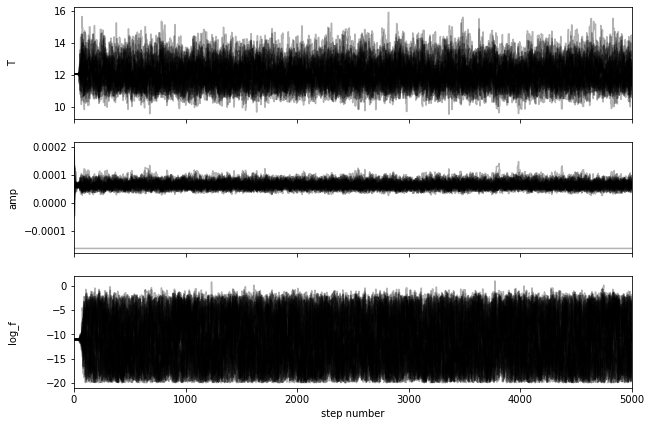

In [35]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['T', 'amp', 'log_f']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [38]:
tau = sampler.get_autocorr_time()
print(tau)
flat_samples = sampler.get_chain(discard=300, thin=15, flat=True)
print(flat_samples.shape)

[        nan 61.6857547  62.53779158]
(10016, 3)


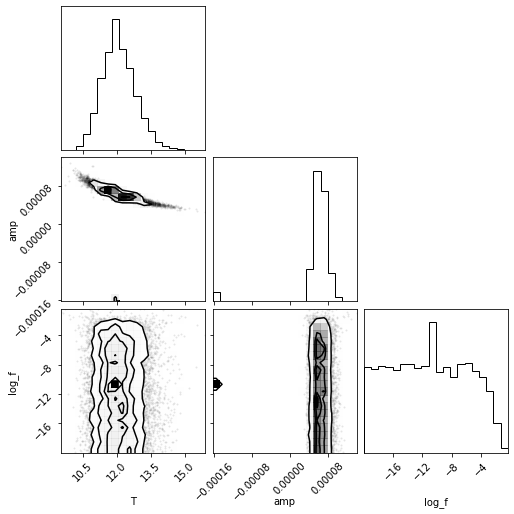

In [39]:
fig = corner.corner(
    flat_samples, labels=labels
);

In [44]:
best_fit = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = r"$\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    
    if labels[i] == 'T':
        title = txt
    best_fit.append(mcmc[1])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

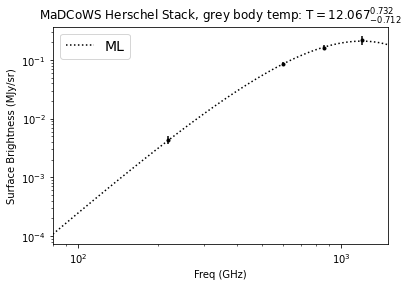

In [45]:
plt.errorbar(x.value, y.value, yerr=yerr.value, fmt=".k", capsize=0)
#plt.plot(x0, bb(x0), "k", alpha=0.3, lw=3, label = 'Truth')

model_ml = lambda v: best_fit[1]*(1-np.exp(-(v.value/3000)**1.95))*models.BlackBody(temperature = best_fit[0]*u.K, scale = 1*u.MJy/u.sr)(v).value

plt.plot(x0, model_ml(x0), ":k", label="ML")
plt.title('MaDCoWS Herschel Stack, grey body temp: '+ title )
plt.legend(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlim(80, 1500)

plt.savefig('./plots/herschel/t_only_greybody_mdcw_mcmc.pdf')
plt.savefig('./plots/herschel/t_only_greybody_mdcw_mcmc.png', dpi = 300)

plt.xlabel("Freq (GHz)")
plt.ylabel("Surface Brightness (MJy/sr)");

# Fixed v0 Fit

Maximum likelihood estimates:
T = 12.935
amp = 4.242e-05
beta = 1.825
f = 1.000e-01


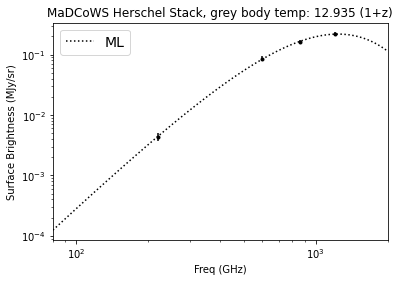

In [24]:
nll = lambda *args: -v0_fixed_log_likelihood(*args)
initial = np.array([20, 1e-5, 1.95, np.log(f_true)])

soln = minimize(nll, initial, args=(x, y, yerr))
T_ml, a_ml, beta_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("T = {0:.3f}".format(T_ml))
print("amp = {0:.3e}".format(a_ml))
print("beta = {0:.3f}".format(beta_ml))


print("f = {0:.3e}".format(np.exp(log_f_ml)))

model_ml = lambda v: a_ml*(1-np.exp(-(v.value/3000)**beta_ml))*models.BlackBody(temperature = T_ml*u.K, scale = 1*u.MJy/u.sr)(v).value

x0 = np.linspace(80, 2000, 100)*u.GHz

plt.errorbar(x.value, y.value, yerr=yerr.value, fmt=".k", capsize=0)
#plt.plot(x0, bb(x0), "k", alpha=0.3, lw=3, label = 'Truth')
plt.plot(x0, model_ml(x0), ":k", label="ML")
plt.title('MaDCoWS Herschel Stack, grey body temp: {0:.3f} (1+z)'.format(T_ml) )
plt.legend(fontsize=14)
plt.xlim(80, 2000)
plt.xscale('log')
plt.yscale('log')


plt.xlabel("Freq (GHz)")
plt.ylabel("Surface Brightness (MJy/sr)");

In [25]:
pos = soln.x + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, v0_fixed_log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);
pk.dump(sampler, open('v0_fixed_sampler.p', 'wb'))


  0%|          | 0/5000 [00:00<?, ?it/s]/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [13:36<00:00,  6.12it/s]


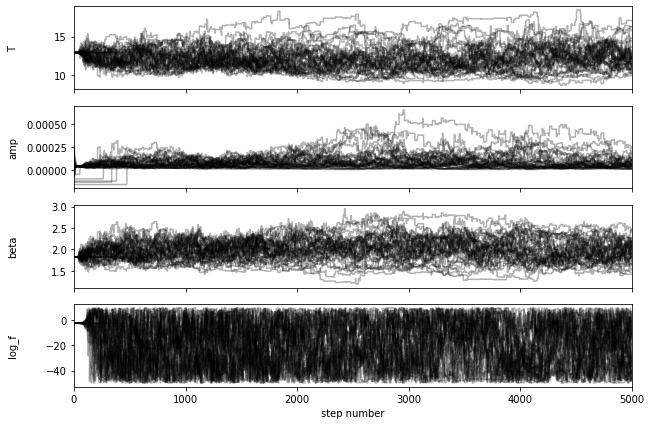

In [26]:
#except: pk.load( open('v0_fixed_sampler.p', 'rb'))
sampler = pk.load( open('v0_fixed_sampler.p', 'rb'))
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['T', 'amp', 'beta', 'log_f']
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

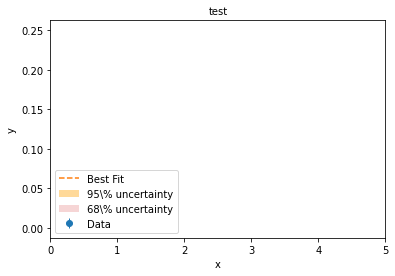

In [28]:

samples = sampler.get_chain()

c = ChainConsumer()
chain = sampler.chain[:, 500:, :]
uniform = chain.reshape((-1, ndim))

c.add_chain(uniform, parameters = ['T', 'amp', 'beta', 'log_f'], name="Uniform")

def model(v, best_fit):
    return best_fit[1]*(1-np.exp(-(v.value/3000)**best_fit[2]))*models.BlackBody(temperature = best_fit[0]*u.K, scale = 1*u.MJy/u.sr)(v).value

def plot(bounds, title):
    fig, ax = plt.subplots()
    plt.errorbar(x.value, y.value, yerr=yerr.value, fmt="o", lw=1, label="Data")
    ax.plot(x0, bounds[2, :], label="Best Fit", ls="--"),
    plt.fill_between(x0, bounds[0, :], bounds[-1, :], 
                     label="95\% uncertainty", fc="#FFA000", alpha=0.4)
    plt.fill_between(x0, bounds[1, :], bounds[-2, :], 
                     label="68\% uncertainty", fc="#D32F2F", alpha=0.2)
    ax.legend(loc=3)
    ax.set_title(title, fontsize=10);
    ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_xlim(0, 5)

shuffled = np.copy(uniform)
np.random.shuffle(shuffled)
# Row by row construct the prediction of our model using 1000 model realisations
realisations = np.array([model(x0, row[:3]) for row in shuffled[:1000, :]])
bounds = np.percentile(realisations, 100 * norm.cdf([-2, -1, 0, 1, 2]), axis=0)
plot(bounds, 'test')


In [29]:
#tau = sampler.get_autocorr_time()
flat_samples = sampler.get_chain(discard=300, thin=15, flat=True)
print(flat_samples.shape)

(10016, 4)


[[1.34991669e+01 2.78317134e-05 1.62866884e+00]
 [1.33132102e+01 3.29409747e-05 1.71426473e+00]
 [1.08348942e+01 1.22608858e-04 2.12922883e+00]
 ...
 [1.20411358e+01 6.98645543e-05 2.02473731e+00]
 [1.13242483e+01 8.22341545e-05 1.96569038e+00]
 [1.26987995e+01 5.14725017e-05 1.92210287e+00]]


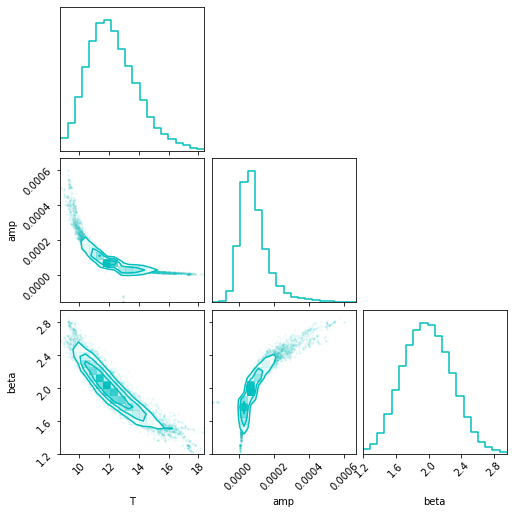

In [30]:
print(flat_samples.T[:3].T)
fig = corner.corner(
    flat_samples.T[:3].T, labels=labels[:4], color = 'c', smooth1d = True
);

In [31]:
best_fit = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = r"$\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    
    if labels[i] == 'T':
        title = txt
    best_fit.append(mcmc[1])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

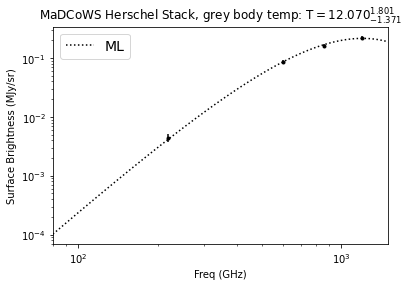

In [32]:


plt.errorbar(x.value, y.value, yerr=yerr.value, fmt=".k", capsize=0)
#plt.plot(x0, bb(x0), "k", alpha=0.3, lw=3, label = 'Truth')


model_ml = lambda v: best_fit[1]*(1-np.exp(-(v.value/3000)**best_fit[2]))*models.BlackBody(temperature = best_fit[0]*u.K, scale = 1*u.MJy/u.sr)(v).value

plt.plot(x0, model_ml(x0), ":k", label="ML")
plt.title('MaDCoWS Herschel Stack, grey body temp: '+ title )
plt.legend(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlim(80, 1500)

plt.savefig('./plots/herschel/v0_fixed_greybody_mdcw_mcmc.pdf')
plt.savefig('./plots/herschel/v0_fixed_greybody_mdcw_mcmc.png', dpi = 300)

plt.xlabel("Freq (GHz)")
plt.ylabel("Surface Brightness (MJy/sr)");

In [18]:
sampler = pk.load( open('v0_fixed_sampler.p', 'rb'))
flat_samples = sampler.get_chain(discard=300, thin=15, flat=True)

labels = ['T', 'amp', 'beta', 'log_f']

best_fit = []

for i in range(4):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = r"$\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    
    if labels[i] == 'T':
        title = txt
    best_fit.append(mcmc[1])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [19]:
#Predicted deltaT from dust model
model_ml = lambda v: (best_fit[1]*(1-np.exp(-(v.value/3000)**best_fit[2]))*models.BlackBody(temperature = best_fit[0]*u.K, scale = 1*u.MJy/u.sr)(v).value)*u.MJy/u.sr

v_90 = 90*u.GHz
v_150 = 150*u.GHz
v_220 = 220*u.GHz

aperture_size = (np.pi*(1.2*u.arcmin)**2).to(u.sr)

pixel_size_90, pixel_size_150, pixel_size_220  = 0.008333*60*220/90*u.arcmin, 0.008333*60*220/150*u.arcmin, 0.008333*60*220/220*u.arcmin

pixel_area_90, pixel_area_150, pixel_area_220 =  pixel_size_90**2,  pixel_size_150**2, pixel_size_220**2

x_90, x_150, x_220 = 90/56.8, 150/56.8, 220/56.8

conversion_90 = 270.33*10**6*1*10**-6/2.73*x_90**4*np.exp(x_90)/(np.exp(x_90)-1)**2*(np.pi*(pixel_size_90)/(180*60))**2
conversion_150 = 270.33*10**6*1*10**-6/2.73*x_150**4*np.exp(x_150)/(np.exp(x_150)-1)**2*(np.pi*(pixel_size_150)/(180*60))**2
conversion_220 = 270.33*10**6*1*10**-6/2.73*x_220**4*np.exp(x_220)/(np.exp(x_220)-1)**2*(np.pi*(pixel_size_220)/(180*60))**2

print((model_ml(v_90)*aperture_size).to(u.Jy)/conversion_90)
print((model_ml(v_150)*aperture_size).to(u.Jy)/conversion_150)
print((model_ml(v_220)*aperture_size).to(u.Jy)/conversion_220)

2.384932400659172 Jy / arcmin2
22.59871081717124 Jy / arcmin2
157.05482064764638 Jy / arcmin2


In [33]:
print((model_ml(v_90)*aperture_size).to(u.Jy))
print((model_ml(v_150)*aperture_size).to(u.Jy))

percs = [16,84]

amps = np.percentile(flat_samples[:, 1], [16, 50, 84])
betas = np.percentile(flat_samples[:, 2], [16, 50, 84])
temps = np.percentile(flat_samples[:, 0], [16, 50, 84])

flux_90 = []
flux_150 = []

for i in range(len(amps)):
    model_ml = lambda v: (amps[i]*(1-np.exp(-(v.value/3000)**betas[i]))*models.BlackBody(temperature = temps[i]*u.K, scale = 1*u.MJy/u.sr)(v).value)*u.MJy/u.sr
    flux_90.append((model_ml(v_90)*aperture_size).to(u.Jy))
    flux_150.append((model_ml(v_150)*aperture_size).to(u.Jy))
    
print(flux_90[1], flux_90[1]-flux_90[2], flux_90[0]-flux_90[1])
print(flux_150[1], flux_150[1]-flux_150[2], flux_150[0]-flux_150[1])

5.7854411379355547e-05 Jy
0.0004593300386899398 Jy
6.10490144495243e-05 Jy 3.194603070168758e-06 Jy 3.005172480118447e-08 Jy
0.0004094047628956179 Jy -4.9925275794321876e-05 Jy -6.059812625094387e-05 Jy


In [22]:
cur_map = enmap.read_map('/gpfs/fs0/project/r/rbond/jorlo/freq_maps/stitched_Beam220_filteredMap.fits')


MOO J0854+0704
7.1126952270693895


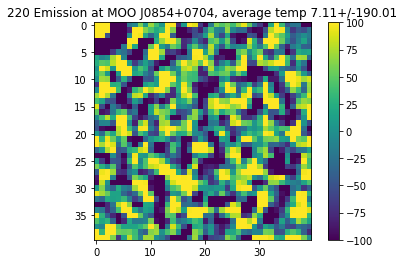

In [91]:
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

hdu = fits.open('/gpfs/fs0/project/r/rbond/jorlo/freq_maps/stitched_Beam220_filteredMap.fits')


ra = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
dec = mdcw_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
rich = mdcw_catalog[1].data['Rich']
z = mdcw_catalog[1].data['Photz']

names_cut = {'MOO J0015+0801','MOO J0917+1456','MOO J0936+0336','MOO J1116+1653','MOO J1350+0036','MOO J1355-0114','MOO J2349+0541'}

names_flag = [True]*len(names)

for i, name in enumerate(names):
    if name in names_cut:
        names_flag[i] = False

        
ra = ra[names_flag]
dec = dec[names_flag]
rich = rich[names_flag]
names = names[names_flag]
z = z[names_flag]

cent_temps = np.zeros(len(ra))

for k in range(len(ra)):
    stamp = reproject.postage_stamp(cur_map, ra[k], dec[k], 20., 0.5)
    if stamp is None: continue
    if not np.any(stamp[0]): continue
    if k == 824:
        print(names[k])
        plt.imshow(stamp[0], vmin = -100, vmax = 100)
        plt.colorbar()
        plt.title('220 Emission at {}, average temp {:.2f}+/-{:.2f}'.format(names[k],np.mean(stamp[0]),np.std(stamp[0])))
        plt.savefig('./plots/MOOJ0854+0704_220.pdf')
        #print(stamp[0].tolist())
        print(np.mean(stamp[0]))
    cent_temps[k] = central_emission(stamp, 1.2)[0]


In [39]:
rescales = np.zeros(len(cent_temps))

for i, cent_temp in enumerate(cent_temps):
    rescales[i] = cent_temp/157.05482064764638

In [40]:
print(rescales)

[-3.1291355   0.          0.         ...  0.70671009  6.18854995
 -1.09794349]


In [49]:
catalog = {}
model_ml = lambda v: (best_fit[1]*(1-np.exp(-(v.value/3000)**best_fit[2]))*models.BlackBody(temperature = best_fit[0]*u.K, scale = 1*u.MJy/u.sr)(v).value)*u.MJy/u.sr

for i in names:
    catalog[i] = {'90':0, '150':0}

    
ref_90 = ((model_ml(v_90)*aperture_size).to(u.Jy)/conversion_90).value
ref_150 = ((model_ml(v_150)*aperture_size).to(u.Jy)/conversion_150).value
for i, name in enumerate(names):
    catalog[name]['90'] = ref_90*rescales[i]
    catalog[name]['150'] = ref_150*rescales[i]

In [50]:
print(catalog)

{'MOO J0001+1428': {'90': -7.462776636480724, '150': -70.71442823887033}, 'MOO J0001+3644': {'90': 0.0, '150': 0.0}, 'MOO J0001+3440': {'90': 0.0, '150': 0.0}, 'MOO J0001-2447': {'90': 6.442295129954038, '150': 61.04473426603746}, 'MOO J0001-2533': {'90': 13.926812489906776, '150': 131.9651693177484}, 'MOO J0002-0820': {'90': 0.2648906293069728, '150': 2.510002685288799}, 'MOO J0002+1751': {'90': -6.4562594756928045, '150': -61.177055086121975}, 'MOO J0003-0903': {'90': 7.59845321255172, '150': 72.00004778366116}, 'MOO J0003-2925': {'90': -1.3389755189885788, '150': -12.68762189508237}, 'MOO J0003-1341': {'90': 2.068598501976156, '150': 19.60125131013029}, 'MOO J0004-0232': {'90': -12.50015847121621, '150': -118.4467393632422}, 'MOO J0004+0024': {'90': -1.1219959355230178, '150': -10.63160602703797}, 'MOO J0004+0108': {'90': -1.852282518639985, '150': -17.551523464093634}, 'MOO J0005+1329': {'90': 0.4212196384512996, '150': 3.9913168177191856}, 'MOO J0005+0024': {'90': -1.3146472030731

In [51]:
pk.dump(catalog, open('dust_catalog.p', 'wb'))

In [61]:
print(np.where((cent_temps == max(cent_temps))))

(array([824]),)


In [79]:
print(catalog[names[824]])

{'90': 234.44513571326874, '150': 2221.512787118103}


In [80]:
cent_temps.sort()

In [81]:
print(cent_temps)

[-1626.98689368 -1573.86946067 -1517.27198816 ...  1672.12151518
  1840.33242406 15438.90247413]


# Modeling Indv. Clusters

In [36]:
hersch_ems = pk.load(open('./pks/mdcw_ems_with220.pk', 'rb'))
x = np.array([1362.69, 250, 350, 500])*u.um
x = x.to(u.GHz, equivalencies=u.spectral())

yerr = np.array([0.0006369, 0.01451, 0.011704, 0.0075511])*u.MJy/u.sr



In [39]:
fits = dict()

for cluster in hersch_ems.keys():
    y = hersch_ems[cluster][0:4]*u.MJy/u.sr
    richness = hersch_ems[cluster][-1]
    if len(y) != 4: continue
    if 1>richness or richness > 1000: continue
    #print(y)
    
    nll = lambda *args: -v0_fixed_log_likelihood(*args)
    initial = np.array([20, 1e-5, 1.95, np.log(0.1)])

    try: soln = minimize(nll, initial, args=(x, y, yerr))
    except:
        print('Fit failed')
        continue
    T_ml, a_ml, beta_ml, log_f_ml = soln.x
    data = [T_ml, a_ml, beta_ml, log_f_ml, richness]
    fits[cluster] = data

Fit failed
Fit failed


In [40]:
print(fits)

{'MOO J1454+0032': [8.901291453182548, 6.142541545966571e-06, -0.5577715710832745, -2.3025850929940455, 16], 'MOO J0104-2803': [4.714076640055594, 8.931233781086515, 7.082703990567111, -2.3025850929940455, 16], 'MOO J0118-2714': [28.003924260900543, 1.96615939445467e-06, 3.189694403342345, -2.3025850929940455, 33], 'MOO J0126-2947': [5.213169994133718, 1.5300902016636486, 6.5559192124873205, -2.3025850929940455, 44], 'MOO J0127-2759': [8.502305831757688, 0.0013725133818505055, 2.968963780075916, -2.3025850929940455, 9], 'MOO J0128-2912': [25.732728761451032, 1.485577627579366e-06, 0.09883881258760738, -2.3025850929940455, 28], 'MOO J0135-2743': [5.32356854537556, 3.6987198501753094, 7.172133220123716, -2.3025850929940455, 29], 'MOO J0125-3041': [4.84459114323222, 4.837354423806807, 7.139786204142588, -2.3025850929940455, 28], 'MOO J1206-0136': [4.784609105915649, 13.253103259273209, 7.0961515404925235, -2.3025850929940455, 6], 'MOO J1216-0033': [20.475773962449676, 1.836771027101418e-0

In [41]:
pk.dump(fits, open('./pks/mdcw_dust_models.pk', 'wb'))